# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Data Curation Part 2

The dataset used is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories


In [3]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [4]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [5]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
%matplotlib inline

## Now to SCALE UP

Let's look at all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [9]:
dataset_names = [
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [10]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load(workers=4))

# Now, time for a coffee break!!
# By the way, I put the biggest datasets first.. it gets faster.

Loading dataset Tools_and_Home_Improvement


100%|██████████████████████████████████████████████████████████████████████████████| 1474/1474 [31:47<00:00,  1.29s/it]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 32.7 mins
Loading dataset Cell_Phones_and_Accessories


100%|██████████████████████████████████████████████████████████████████████████████| 1289/1289 [21:18<00:00,  1.01it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 21.6 mins
Loading dataset Toys_and_Games


100%|████████████████████████████████████████████████████████████████████████████████| 891/891 [11:51<00:00,  1.25it/s]


Completed Toys_and_Games with 340,479 datapoints in 12.0 mins
Loading dataset Appliances


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:48<00:00,  1.96it/s]


Completed Appliances with 28,625 datapoints in 0.9 mins
Loading dataset Musical_Instruments


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [01:29<00:00,  2.39it/s]


Completed Musical_Instruments with 66,829 datapoints in 1.6 mins


In [11]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,811,408 items


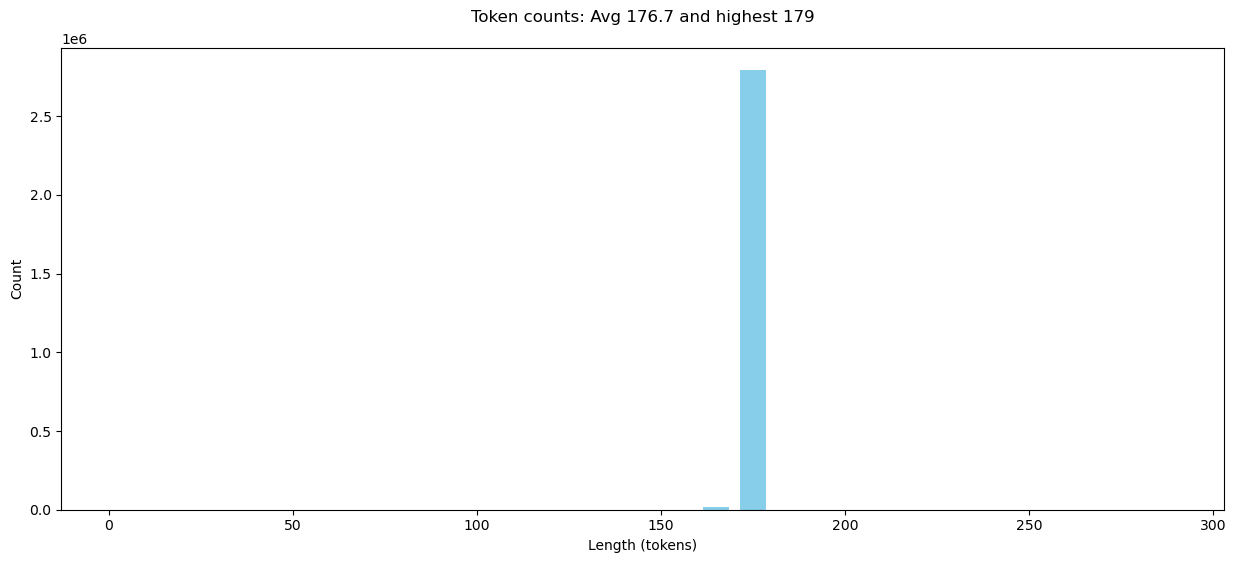

In [12]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

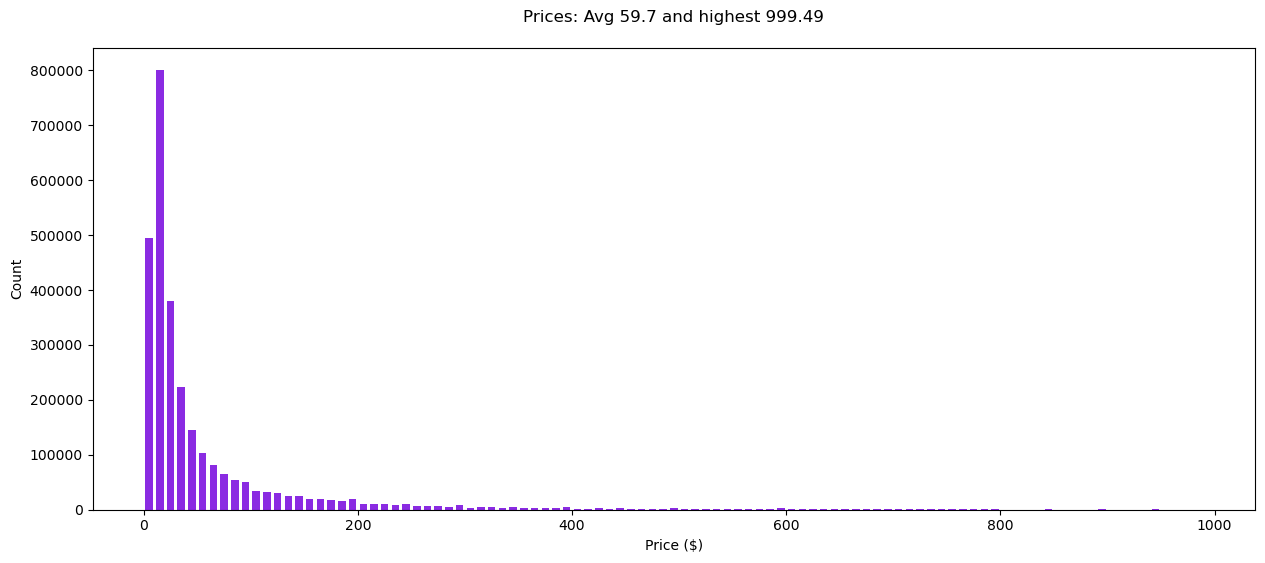

In [13]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

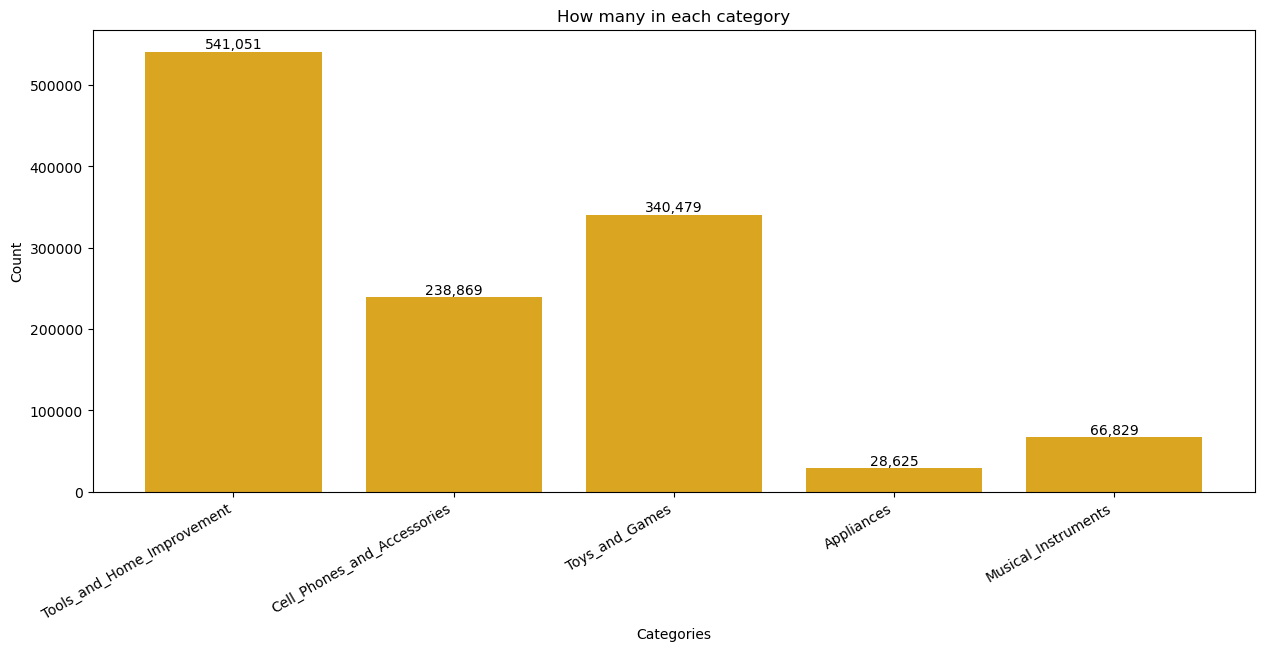

In [11]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

# Objective

Craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [12]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [13]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 225,597 items in the sample


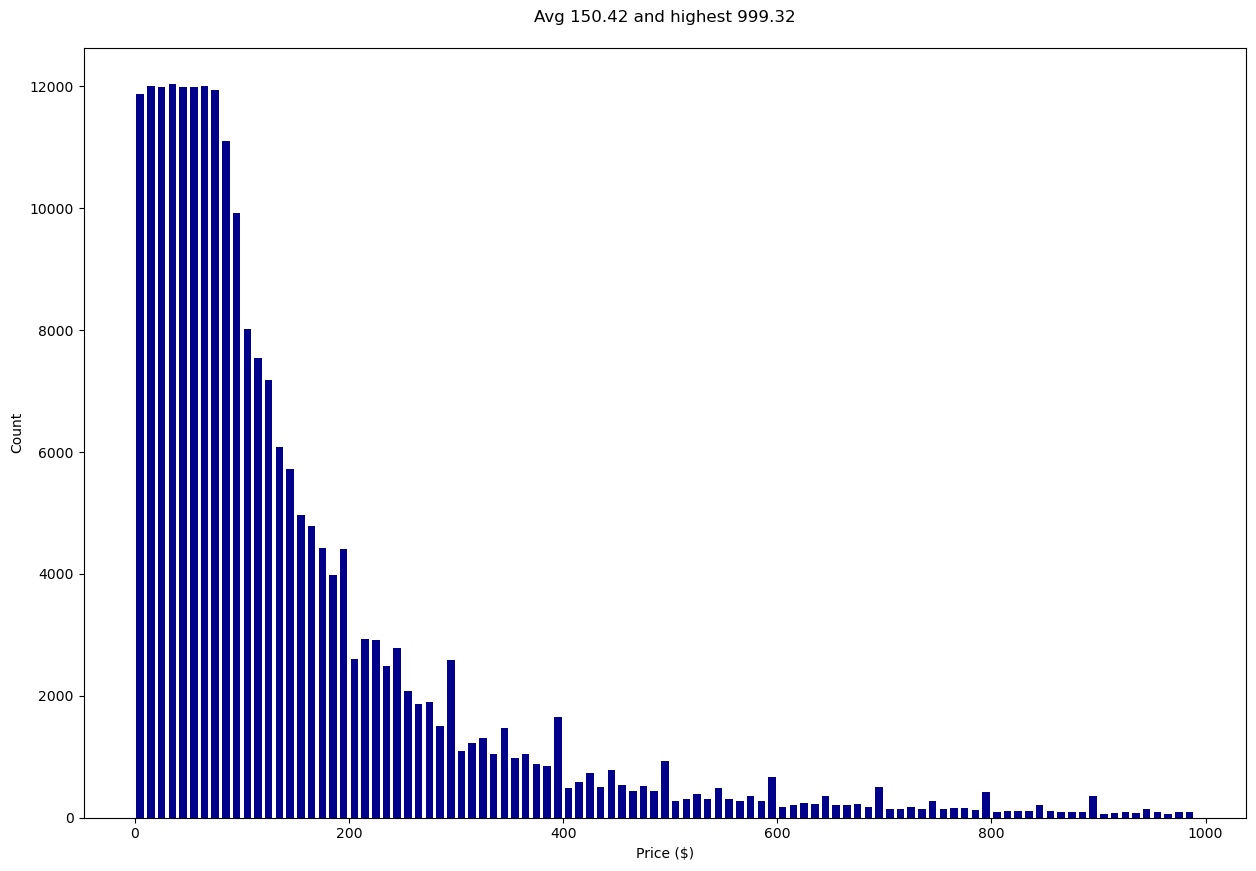

In [14]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

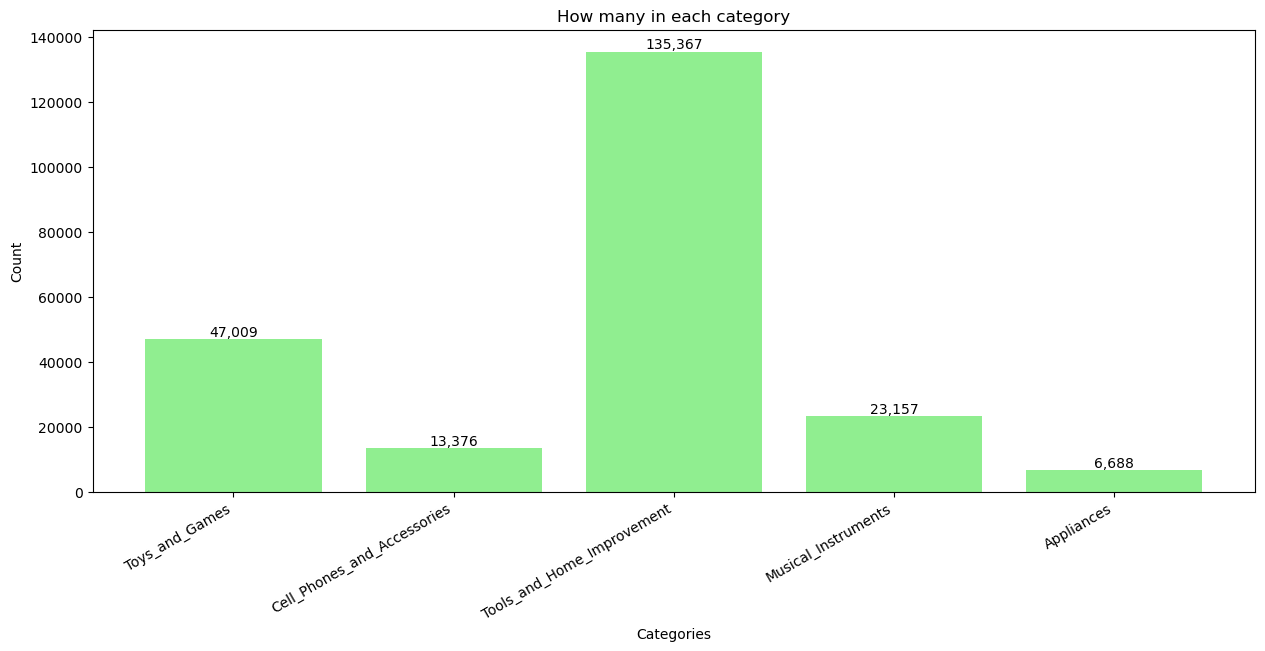

In [ ]:

# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

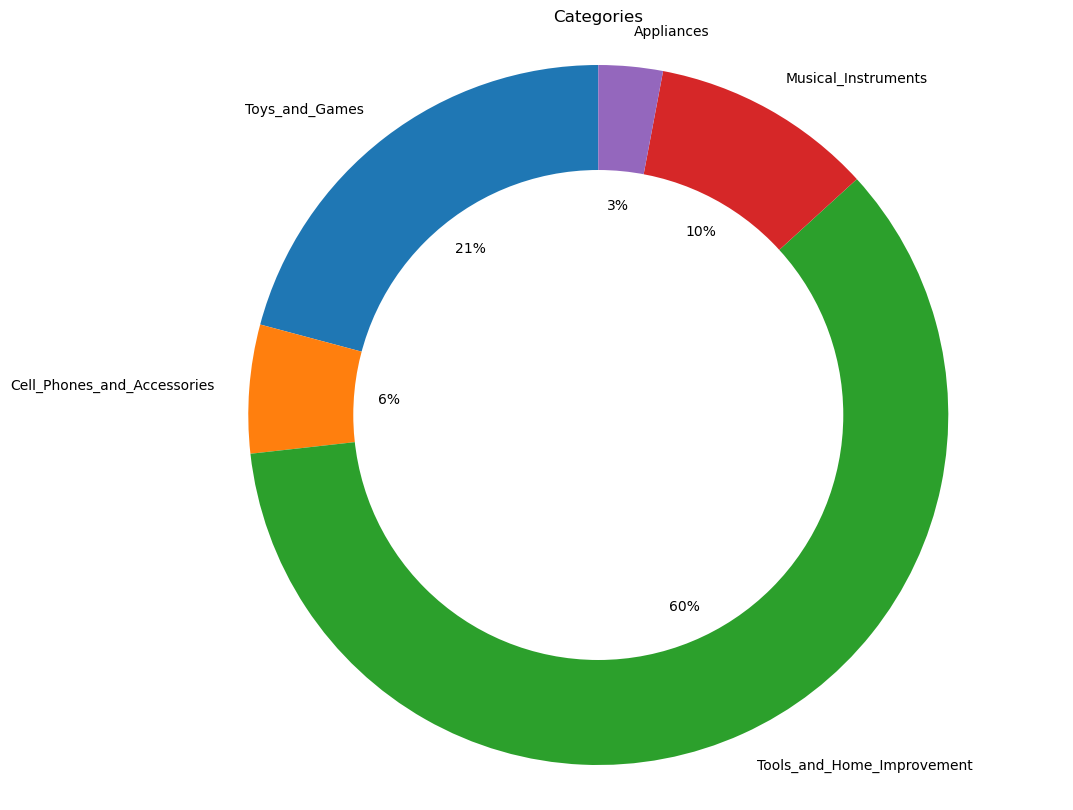

In [ ]:
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

# Dataset Curated!

We've crafted an excellent dataset.

Let's do some final checks

In [17]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [19]:
report(sample[12000])

How much does this cost to the nearest dollar?

Vavies Case for Galaxy A71 Case Fit A71 4G) Samsung A71 5G Phone Case for Girls,Slim Shockproof Clear Pattern Soft Flexible TPU Protective Cover Cases for Samsung Galaxy A71 Flower)
Compatibility Compatible with Samsung Galaxy A71 5G. Material Exclusively made by the TPU Material which carries on with SUPER Clear, Ultra Slim, Lightweight and while provides protection against daily wear and tear, scratches, marks and scrapes. Features Keep the back and side of your device from scratches, scrapes and fingerprints and yet durable & lightweight case. Package Content 1 x Cover Case for Samsung Galaxy A71 5G Galaxy A71 5G Clear Case, Compatible with Samsung Galaxy A71 5G Galaxy A71 design phone case. ULTRA

Price is $11.00
[13, 22931, 20865, 271, 7117, 374, 400, 806, 13, 410]
['.', ' UL', 'TRA', '\n\n', 'Price', ' is', ' $', '11', '.', '00']


## Observation

An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.



It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


In [25]:
random.seed(42)
random.shuffle(sample)
train = sample[:100_000]
test = sample[100_000:102_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 100,000 items and test set of 2,000 items


# Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [26]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [27]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [ ]:
# Uncomment these lines if you're ready to push to the hub, and replace my name with your HF username

HF_USER = "my name"
DATASET_NAME = f"{HF_USER}/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/NovaCrazy/pricer-data/commit/4fafc81fd25b366f92774d50af1eccaddf766a05', commit_message='Upload dataset', commit_description='', oid='4fafc81fd25b366f92774d50af1eccaddf766a05', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/NovaCrazy/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='NovaCrazy/pricer-data'), pr_revision=None, pr_num=None)

In [29]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)